# Invitation Homes - OTV Project
## PSI Checking
### Library Imports

In [2]:
### Standard Imports - Sorry PEP8 fans, do not look below
import pandas as pd, numpy as np, os, re, json, sys
from pathlib import Path
from datetime import datetime

# from joshberry.utils import *
# from joshberry.feats import *

## Specific Imports
from matplotlib import pyplot as plt
import matplotlib as mpl
import plotly.express as px
%timeit
%matplotlib inline

#### DataRobot API tokens (I save my API token as an environmental variable)
ENDPOINT_URL = "https://app.datarobot.com/api/v2"

if os.environ.get("DR_API_TOKEN") == None:
    API_TOKEN = "OR__pasteyourtokenherefromthedatarobotbyclickinginthetopright"
else:
    API_TOKEN = os.environ.get("DR_API_TOKEN")

### Display options for notebooks
pd_options = {'display.max_rows': 25,'display.max_columns': 500}
[pd.set_option(option, setting) for option, setting in pd_options.items()]

### set path directories
curr_dir = Path(os.getcwd())
data_dir = Path(curr_dir.parents[0] / 'data/')
artifacts_dir = Path(curr_dir.parents[0] / 'artifacts/')

print('Current Directory is: ', str(curr_dir))

Current Directory is:  /Users/justin.swansburg/python_envs/data-science-scripts/joshberry/client-use-cases/invitationhomes/otv/notebooks


In [3]:
### Common project specific variables
FILENAME = 'SNOWFLAKE_RENEWAL FEATURES_v0.3.csv_604278a7559ded2c5d850c01.csv'  # original data

GROUP_COL = 'yyyymm'
REF_VALUE = 'OLDEST_BACKTEST_TRAINING'
DATE_COL = 'LEASE_END_DATE_C'

### Data Import & Re-Export

The data contains very few, very old rows. This confuses DataRobot's OTV partioning so we'll just remove some of those rows and re-export the data.

In [6]:
indata = pd.read_csv(Path(data_dir) / FILENAME, low_memory=False)

In [7]:
indata[DATE_COL] = pd.to_datetime(indata[DATE_COL])

In [14]:
# add a filter to exclude really old ones because I saw some weird data there
outdata = indata.copy()

outdata['exclude'] = 0
outdata['exclude'] = np.where((outdata[DATE_COL] > '2020-12-31' )
                            , 1
                            , outdata['exclude'])
outdata['exclude'] = np.where((outdata[DATE_COL] < '2014-04-01')
                            , 1
                            , outdata['exclude'])

outdata[outdata['exclude']==0].to_csv(Path(data_dir) / 'Training_And_Holdout_Truncated.csv', index=False, chunksize=20000)

### Upload to DR and configure backtests

In [16]:
# done with DR GUI

### Configure Group Column
All we want to do here is to create a GROUP_COL which identifies each "time slice" that we'll interate over to calculate PSI. 

Usually I will aggregete to a month, week, or day. 

Another thing I like to do is aggregate a longer time period (i.e training) into a single group that is used as my reference period.

In [30]:
# group months for analysis
# also, anything in backtest4 training and before, will be "reference"
# also, remove holdout from analysis
# These dates were obtained by configuring in DataRobot GUI and hardcoding it here
outdata[GROUP_COL] = np.where(outdata[DATE_COL] < '2019-10-01'
                             , REF_VALUE
                             , 'YYYYMM: ' + outdata[DATE_COL].dt.strftime('%Y%m').astype('str')
                            )

# exclude holdout
df = outdata[outdata[DATE_COL]<'2020-10-01']


In [31]:
# start with only these features from list rr_v5

starting_feat_list= ['CMA_RENT_C','LEASE_END_DATE_C','LOCATION_SCORE_C','UW_RENT_C','LEASE_RENT_C','CURRENT_LEASE_TERM_MONTHS_C','TOTAL_MONTHS_IN_HOME_C',
'PROMOTION_INCENTIVE_COST_C','CURRENT_LEASE_TERM_BUCKET_C','HOUSING_RENT_C','UNADJUSTED_CMA_RENT_C','PROPOSED_NEW_RENT_YEAR_2_C','TOTAL_RENT_C',
'PORTFOLIO_SUBMARKET_C','CMA_PLUS_TWO_PERCENT_C','INITIAL_PROPOSED_NEW_RENT_C','VARIANCE_CURRENT_TO_CMA_FORMULA_PERCENT_C','VARIANCE_CURRENT_TO_CMA_FORMULA_C','DAYS_LEASE_START_TO_MOVE_IN_C',
'BULK_POST_DECISION_CMA_RENT_C','BULK_PRE_DECISION_CMA_RENT_C','BULK_PRICING_RENT_DRIVER_C','BULK_RENT_ALERT_C','OVERALL_ASSET_SCORE_C','PROPERTY_SCORE_C',
'MARKET_C','RESIDENT_INITIAL_RENT_C','BULK_SUBJECT_AVM_RENT_C','OTHER_FEES_C','POOL_C','TOTAL_MONTHLY_RENT_C','POOL_FORMULA_C','RENT_DRIVER_C',
'YEAR_1_FLOOR_C','YEAR_2_FLOOR_C','PROMOTION_INCENTIVE_C','HAP_RESIDENT_C','SERVICE_ANIMAL_S_C']

## Helper Functions

In [32]:
#function to break numeric variables into bins (smaller bin number means more forgiving tolerance to shifts)
def calc_psi_nums(E,A,Var=1, TimeSliceIndex=1):
    
    N_BINS = 5
    
    # attempt to bin reference data with n bins - but loop to overwrite with less bins in case of error because of infrequent values
    success = False
    while not success:
        try:
            dfBuckets = pd.DataFrame({"E": E, "Bucket": pd.qcut(E, N_BINS, retbins=False)}) 
            success = True
        except Exception as e:
            N_BINS = N_BINS - 1
            success = False
    
    temp = pd.qcut(E, N_BINS, retbins=True)
    bins = temp[-1]
    
    # cut the actual data same way the reference data was cut
    Acut = pd.DataFrame({"A": A, "Bucket": pd.cut(A, bins=bins, include_lowest=True)})
    
    A_temp = pd.DataFrame({})
    i = 0
    for b in dfBuckets.Bucket.unique():
        temp = pd.DataFrame({'Bin': b, 'Perc': float(dfBuckets[dfBuckets['Bucket'] == b].E.count()) / (float(dfBuckets.E.count())+0.000000000001)}, \
                            index=[1]) #index set to 1 to allow total_psi calc
        A_temp = pd.concat([A_temp, temp])
        i = i + 1

    E_temp = pd.DataFrame({})
    i = 0
    for b in dfBuckets.Bucket.unique(): #use bins from Expected Month
        temp = pd.DataFrame({'Bin': b, 'Perc': float(Acut[Acut['Bucket'] == b].A.count()) / (float(Acut.A.count())+0.000000000001)}, \
                             index=[1])
        E_temp = pd.concat([E_temp, temp])
        i = i + 1

    #eliminate 0 percentages in non-null bins    
    for pct in E_temp.Perc:
        if pct == 0:
            E_temp.Perc = E_temp.Perc + .000001
        else:
            E_temp.Perc = E_temp.Perc

    total_psi=0
    Aresult= A_temp.dropna()
    Eresult= E_temp.dropna()
    bin_table_final = pd.DataFrame({})
    for b in Aresult.Bin.unique():
        diff =(Eresult.loc[(Eresult['Bin'] == b), 'Perc'] - Aresult.loc[(Aresult['Bin'] == b), 'Perc'])
        ln =(np.log((Eresult.loc[(Eresult['Bin'] == b), 'Perc'] / Aresult.loc[(Aresult['Bin'] == b), 'Perc'])))
        temp = pd.DataFrame({'Var': Var, 'TimeSlice': TimeSliceIndex, 'Bin': b, 'Perc_Expected':(Aresult.loc[(Aresult['Bin'] == b), 'Perc']), \
                                  'Perc_Actual': (Eresult.loc[(Eresult['Bin'] == b), 'Perc'])}, index=[1])
        bin_table_final = pd.concat([bin_table_final, temp])
        total_psi = total_psi + (diff*ln)

    return(total_psi,bin_table_final)

#E = Expected(reference), A= Actuals(comparison slices)
def categorical_bin(E,A,Var=1,TimeSliceIndex=1):
    EA = pd.DataFrame({"Expected" : E, "Actual" : A })
    
    Categorical_Expected = pd.DataFrame({})
    Categorical_Actual = pd.DataFrame({})

    for val in EA.Expected.unique():  
    
        temp = pd.DataFrame({"Bin" :val, "Count" : EA.Expected[EA.Expected == val].count(), \
                              "Perc" : (float(EA.Expected[EA.Expected == val].count())/(float(EA.Expected.count()) +0.0000000001))},index=[1])
        Categorical_Expected = pd.concat([Categorical_Expected, temp])
        
    for val in EA.Expected.unique():  

        temp = pd.DataFrame({"Bin" :val, "Count" : EA.Actual[EA.Actual == val].count(), \
                              "Perc" : (float(EA.Actual[EA.Actual == val].count())/(float(EA.Actual.count()) +0.0000000001))},index=[1])
        Categorical_Actual = pd.concat([Categorical_Actual, temp])
    
    #eliminate 0 percentages in non-null bins    
    for pct in Categorical_Actual.Perc:
        if pct == 0 or pd.isnull(pct):
            Categorical_Actual.Perc = Categorical_Actual['Perc'].fillna(.000001)
            Categorical_Actual.Perc = Categorical_Actual.Perc + .000002 #currently adds to all
        else:
            Categorical_Actual.Perc = Categorical_Actual.Perc
            
    for pct in Categorical_Expected.Perc:
        if pct == 0:
            Categorical_Expected.Perc = Categorical_Expected.Perc + .000001 #currently adds to all bins if there is a 0.
        else:
            Categorical_Expected.Perc = Categorical_Expected.Perc 

    Categorical_E_Drop = Categorical_Expected.dropna()
    Categorical_A_Drop = Categorical_Actual.dropna()
    
    total_psi=0
    bin_table_final = pd.DataFrame({})
    for b in Categorical_E_Drop.Bin:
    
        diff =(Categorical_Actual.loc[(Categorical_Actual['Bin'] == b), 'Perc'] - Categorical_Expected.loc[(Categorical_Expected['Bin'] == b), 'Perc'])
        ln =(np.log((Categorical_Actual.loc[(Categorical_Actual['Bin'] == b), 'Perc'] / Categorical_Expected.loc[(Categorical_Expected['Bin'] == b), 'Perc'])))
        temp = pd.DataFrame({'Var': Var, \
                                  'TimeSlice': TimeSliceIndex, \
                                  'Bin': b, \
                                  'Perc_Expected':(Categorical_Expected.loc[(Categorical_Expected['Bin'] == b), 'Perc']), \
                                  'Perc_Actual': (Categorical_Actual.loc[(Categorical_Actual['Bin'] == b), 'Perc'])}, index=[1])
        bin_table_final = pd.concat([bin_table_final, temp])
        
        total_psi = total_psi + (diff*ln)
    
    return(total_psi,bin_table_final)

#takes a single dataframe, #string of iteration column
def psi_iter(df,col_list,reference_val,exclude_list):
    
    # any number with less than this number of unique values is assumed categorical
    MIN_CAT_LEVELS=10
    VERIFY_CAT_LEVELS = 100
    
    dfBads=pd.DataFrame({})  #dataframe w/ var,time slice,psi where psi >.1
    dfAll=pd.DataFrame({}) #dataframe to return all var,time slice,psi
    dfAgg=pd.DataFrame({}) #dataframe to return var, bin, perc expected, perc actual column for each # of time slices
    slices = df[col_list].unique()

    for column in list(df):
        if (df[column].dtype) == "object":
            uniquecount = len(df[column].unique())
            if uniquecount >= VERIFY_CAT_LEVELS:
                answer = " "
                while answer != "N" and answer != "Y":
                    answer = input("There are %d unique levels in %s Y to drop, N to keep: " % (uniquecount, column))
                    if answer == "Y":
                        exclude_list.append(column)
                        break
                    if answer == "N":
                        break
    print("*".join('' for a in range(20))) 
    print("Legend for Console Output:")
    print(chr(9745) + ' = PSI is unstable')
    print(chr(9744) + ' = PSI is stable')
    for sl in slices:
        msg=''
        if sl != reference_val: #add and sl <= 5 to shorten test runs
            
            Expected = df[df[col_list] == reference_val]
            Actual = df[df[col_list] == sl]
            x=Expected.dtypes.index  
            
            for i in x:

                if i not in exclude_list:
                    #print(i)    #for debugging if things get weird
                    if np.issubdtype(Expected[i].dtypes, np.number) and len(Expected[i].unique()) > MIN_CAT_LEVELS: 
                        temp2 = pd.DataFrame({"Variable": i,"TimeSlice": sl, "PSI": calc_psi_nums(Expected[i],Actual[i])[0]}) 
                        temp4 = calc_psi_nums(Expected[i],Actual[i],i,sl)[1]
                        dfAgg = pd.concat([dfAgg, temp4])
                        temp2.reset_index()
                        dfAll = pd.concat([dfAll, temp2])
                        
                        if temp2['PSI'].iloc[0] >= .300:
                            dfBads = pd.concat([dfBads, temp2])
                            msg=msg+chr(9745)
                        else:
                            msg=msg+chr(9744)
                    else:
                        temp3 = pd.DataFrame({"Variable": i,"TimeSlice": str(sl), "PSI": categorical_bin(Expected[i].fillna('Missing'),Actual[i].fillna('Missing'))[0]})
                        
                        temp5 = categorical_bin(Expected[i].fillna('Missing'),Actual[i].fillna('Missing'),i,sl)[1]
                        dfAll = pd.concat([dfAll, temp3])
                        dfAgg = pd.concat([dfAgg, temp5])
                        if temp3['PSI'].iloc[0] >= .250:
                            dfBads = pd.concat([dfBads, temp3])
                            msg=msg+chr(9745)
                        else: 
                            msg=msg+chr(9744)
    
        if len(msg)>0:
            print(str(sl) + ' ' + msg)
    if len(dfBads)>0:
        dfBads = dfBads.sort_values('PSI',ascending=False)
        L1=[]
        for i in range(len(dfBads)):
            L1.append(i)
        dfBads.loc[:,'Ind'] = L1

        dfBads = dfBads[['Ind','Variable', 'TimeSlice','PSI']]
        dfBads = dfBads.set_index('Ind')  
    else:
        dfBads = pd.DataFrame({})
        
    L2=[]
    for i in range(len(dfAll)):
        L2.append(i)
    dfAll.loc[:,'Ind'] = L2
    
    dfAll = dfAll[['Ind','Variable', 'TimeSlice','PSI']]
    dfAll = dfAll.set_index('Ind')
   
    return(dfBads,dfAll,dfAgg)

## Execution
Now its time to execute the program. 

Start with a list of columns to include (or just use `df.columns`

Note, you can supply an exclude_list if you want to purposely ignore any variables from the analysis.
Note, if your categorical variable has more than 100 unique values, the program will confirm by asking you to type Y if you want to include it

In [33]:
cols_to_check = [col for col in starting_feat_list if col != DATE_COL]

if GROUP_COL not in cols_to_check:
    cols_to_check.append(GROUP_COL)

df = df[cols_to_check].copy()

df.head(5)

CMA_RENT_C  LOCATION_SCORE_C  UW_RENT_C  LEASE_RENT_C  \
0     1497.00               2.3       1395        1500.0   
1     1163.47               2.8        910        1100.0   
2     1682.00               3.8       1649        1870.0   
3     1575.52               3.7       1269        1663.0   
4     1403.00               2.6       1275        1570.0   

   CURRENT_LEASE_TERM_MONTHS_C  TOTAL_MONTHS_IN_HOME_C  \
0                           12                      91   
1                           12                      89   
2                           12                      88   
3                           12                      89   
4                           12                      88   

   PROMOTION_INCENTIVE_COST_C CURRENT_LEASE_TERM_BUCKET_C  HOUSING_RENT_C  \
0                         NaN                  1 Yr Lease             0.0   
1                         NaN                  1 Yr Lease             0.0   
2                         NaN                  1 Yr Lease             0.0   
3                         NaN                  1 Yr Lease             0.0   
4                         NaN                  1 Yr Lease             0.0   

   UNADJUSTED_CMA_RENT_C  PROPOSED_NEW_RENT_YEAR_2_C  TOTAL_RENT_C  \
0                1877.98                         NaN        1500.0   
1                1202.19                         NaN        1100.0   
2                1682.00                         NaN        1870.0   
3                1524.27                         NaN        1663.0   
4                1403.00                         NaN        1570.0   

  PORTFOLIO_SUBMARKET_C  CMA_PLUS_TWO_PERCENT_C  INITIAL_PROPOSED_NEW_RENT_C  \
0       Las Vegas North                 1526.94                       1568.0   
1       Las Vegas North                 1186.74                       1187.0   
2            Enterprise                 1715.64                       1964.0   
3          Las Vegas NW                 1607.03                       1730.0   
4       Las Vegas North                 1431.06                       1641.0   

   VARIANCE_CURRENT_TO_CMA_FORMULA_PERCENT_C  \
0                                      -0.20   
1                                       5.77   
2                                     -10.05   
3                                      -5.26   
4                                     -10.64   

   VARIANCE_CURRENT_TO_CMA_FORMULA_C  DAYS_LEASE_START_TO_MOVE_IN_C  \
0                              -3.00                          -1567   
1                              63.47                          -1463   
2                            -188.00                          -1461   
3                             -87.48                          -1484   
4                            -167.00                          -1475   

  BULK_POST_DECISION_CMA_RENT_C BULK_PRE_DECISION_CMA_RENT_C  \
0                           NaN                         1497   
1                           NaN                       1163.4   
2                           NaN                       EXCEPT   
3                           NaN                       1575.5   
4                           NaN                          NaN   

  BULK_PRICING_RENT_DRIVER_C BULK_RENT_ALERT_C  OVERALL_ASSET_SCORE_C  \
0                RENT GROWTH                NO                    3.3   
1                   CMA RENT                NO                    3.6   
2                   CMA RENT                NO                    3.9   
3                RENT GROWTH                NO                    4.0   
4                RENT GROWTH                NO                    3.5   

   PROPERTY_SCORE_C   MARKET_C  RESIDENT_INITIAL_RENT_C  \
0               4.4  Las Vegas                   1500.0   
1               4.4  Las Vegas                   1100.0   
2               4.1  Las Vegas                   1870.0   
3               4.4  Las Vegas                   1663.0   
4               4.5  Las Vegas                   1570.0   

   BULK_SUBJECT_AVM_RENT_C  OTHER

In [34]:
# create a list to be passed for variables to be excluded from PSI calculation
# add features to this list if the code errors for being 100% missing
exclude_list =['PROMOTION_INCENTIVE_C']

if GROUP_COL not in exclude_list:
    exclude_list.append(GROUP_COL)

cols = [c for c in df.columns if c not in exclude_list]
checkdf=df[df[GROUP_COL]==REF_VALUE][cols]
if len(checkdf.columns[checkdf.isnull().all()])>0:
    print('Stopping... the following fields are 100% missing in the reference period:')
    print(checkdf.columns[checkdf.isnull().all()])
    del checkdf
else:
    del checkdf
    result_df = psi_iter(df.sort_values(GROUP_COL),GROUP_COL,REF_VALUE,exclude_list)

There are 251 unique levels in PORTFOLIO_SUBMARKET_C Y to drop, N to keep:  Y
There are 1711 unique levels in BULK_POST_DECISION_CMA_RENT_C Y to drop, N to keep:  Y
There are 15966 unique levels in BULK_PRE_DECISION_CMA_RENT_C Y to drop, N to keep:  Y


*******************
Legend for Console Output:
☑ = PSI is unstable
☐ = PSI is stable
YYYYMM: 201910 ☑☐☐☐☐☑☑☐☐☐☐☐☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☐☑☑☐☐
YYYYMM: 201911 ☑☐☐☐☐☑☑☐☐☐☐☐☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☐☑☑☐☐
YYYYMM: 201912 ☑☐☐☐☐☑☑☐☐☐☐☐☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202001 ☑☐☐☐☐☑☑☐☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202002 ☑☐☐☐☐☑☑☐☐☐☐☐☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202003 ☑☐☐☐☐☑☑☐☐☐☐☐☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202004 ☑☐☐☐☐☑☑☐☐☐☐☐☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202005 ☑☐☐☐☐☑☑☐☐☐☐☑☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202006 ☑☐☐☐☐☑☑☐☐☐☐☑☑☐☐☐☐☑☐☐☐☐☐☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202007 ☑☐☐☐☐☑☑☐☐☐☐☑☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202008 ☑☐☐☐☐☑☑☐☐☐☐☑☑☐☐☐☐☑☐☐☐☐☑☐☐☐☐☐☑☑☑☐☐
YYYYMM: 202009 ☑☐☐☐☐☑☑☐☐☐☐☑☑☐☐☐☐☑☐☐☐☐☐☐☐☐☐☐☑☑☑☐☐


## Results
The resulting dataframe `result_df[0]` will show us which variables were unstable and for which date.

The resulting dataframe `result_df[1]` will show us ALL variable-dates and their PSI values.

The resulting dataframe `result_df[2]` will show us aggregated PSI, bins, actual vs predicted percentages

In [35]:
result_df[0]

Variable       TimeSlice        PSI
Ind                                                       
0    PROMOTION_INCENTIVE_COST_C  YYYYMM: 202003  13.381596
1    PROMOTION_INCENTIVE_COST_C  YYYYMM: 202002  12.843090
2    PROMOTION_INCENTIVE_COST_C  YYYYMM: 202009  12.843090
3    PROMOTION_INCENTIVE_COST_C  YYYYMM: 202007  12.843090
4    PROMOTION_INCENTIVE_COST_C  YYYYMM: 202008  12.843090
..                          ...             ...        ...
103                  CMA_RENT_C  YYYYMM: 201910   0.400340
104                TOTAL_RENT_C  YYYYMM: 202006   0.392258
105                TOTAL_RENT_C  YYYYMM: 202007   0.384581
106                TOTAL_RENT_C  YYYYMM: 202005   0.371069
107                TOTAL_RENT_C  YYYYMM: 202009   0.317516

[108 rows x 3 columns]

In [36]:
result_df[0]['Variable'].unique()

array(['PROMOTION_INCENTIVE_COST_C', 'RESIDENT_INITIAL_RENT_C',
       'RENT_DRIVER_C', 'BULK_PRICING_RENT_DRIVER_C', 'YEAR_2_FLOOR_C',
       'YEAR_1_FLOOR_C', 'CMA_PLUS_TWO_PERCENT_C',
       'TOTAL_MONTHS_IN_HOME_C', 'CMA_RENT_C', 'TOTAL_RENT_C'],
      dtype=object)

## Plotting specific features

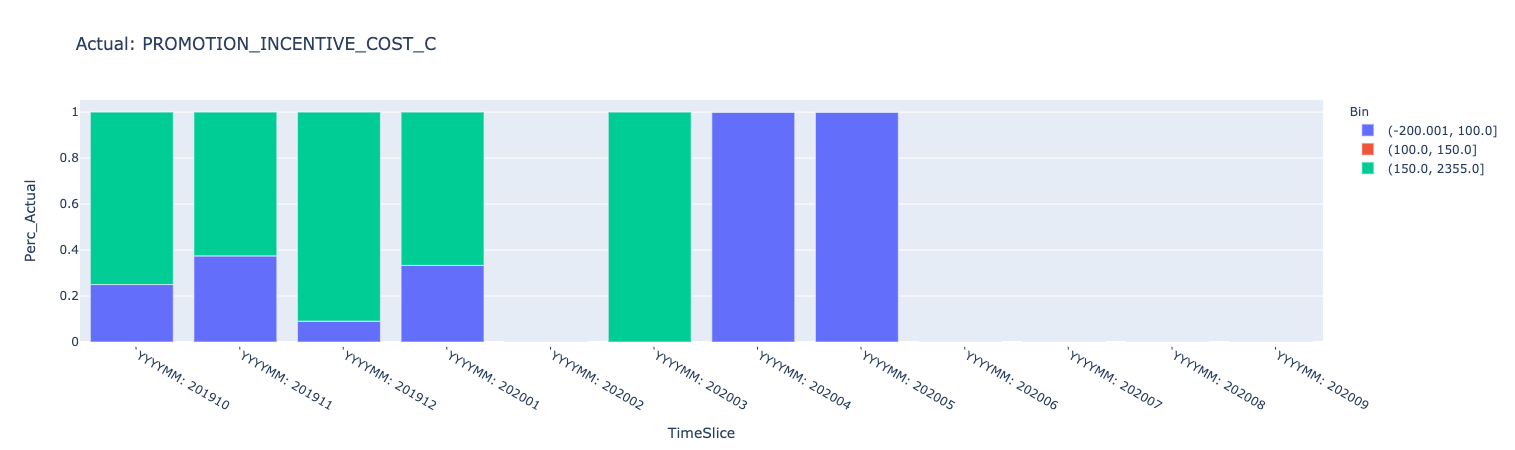

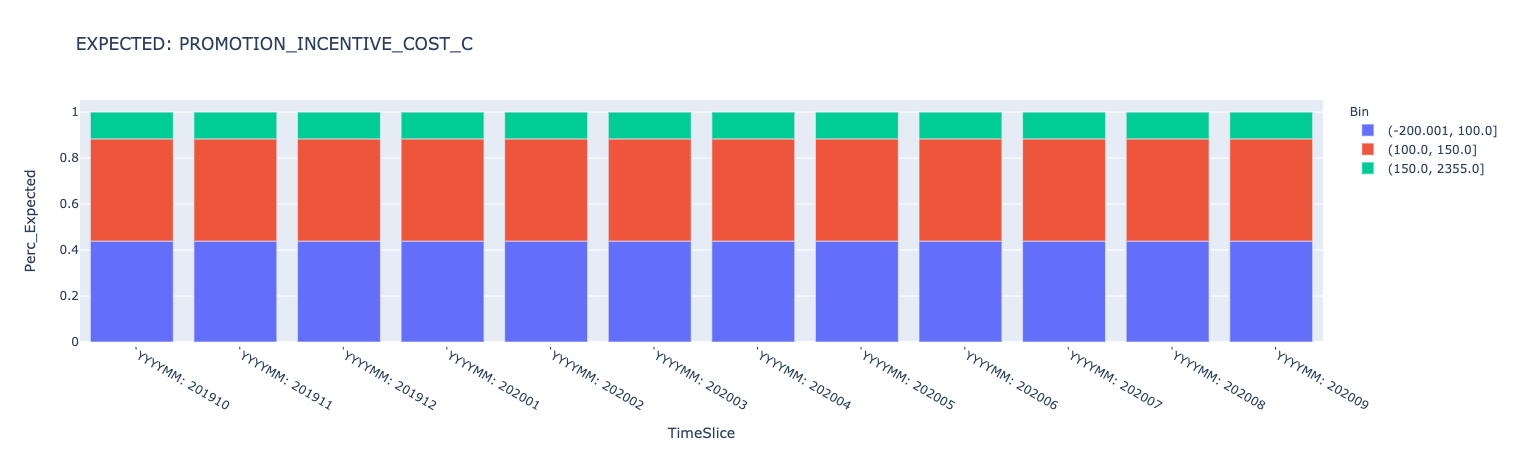

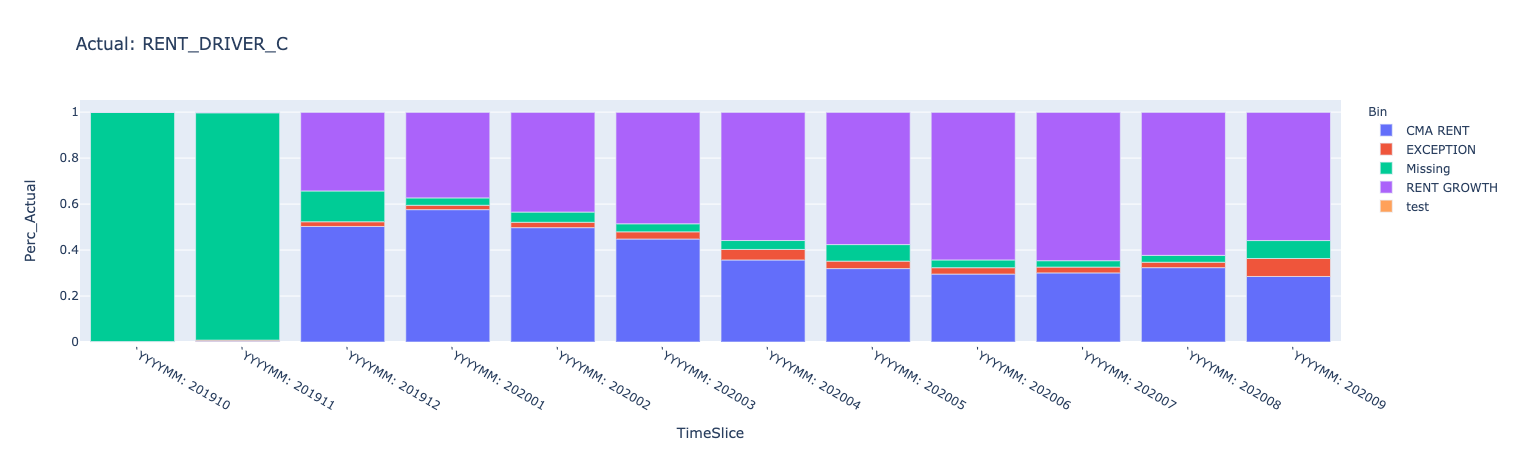

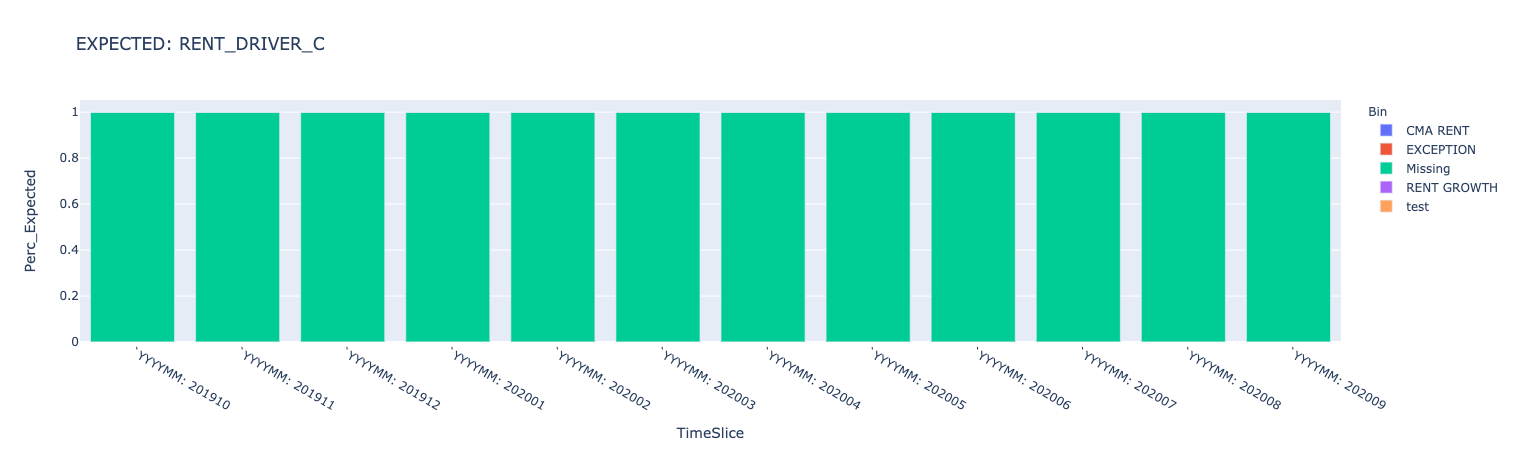

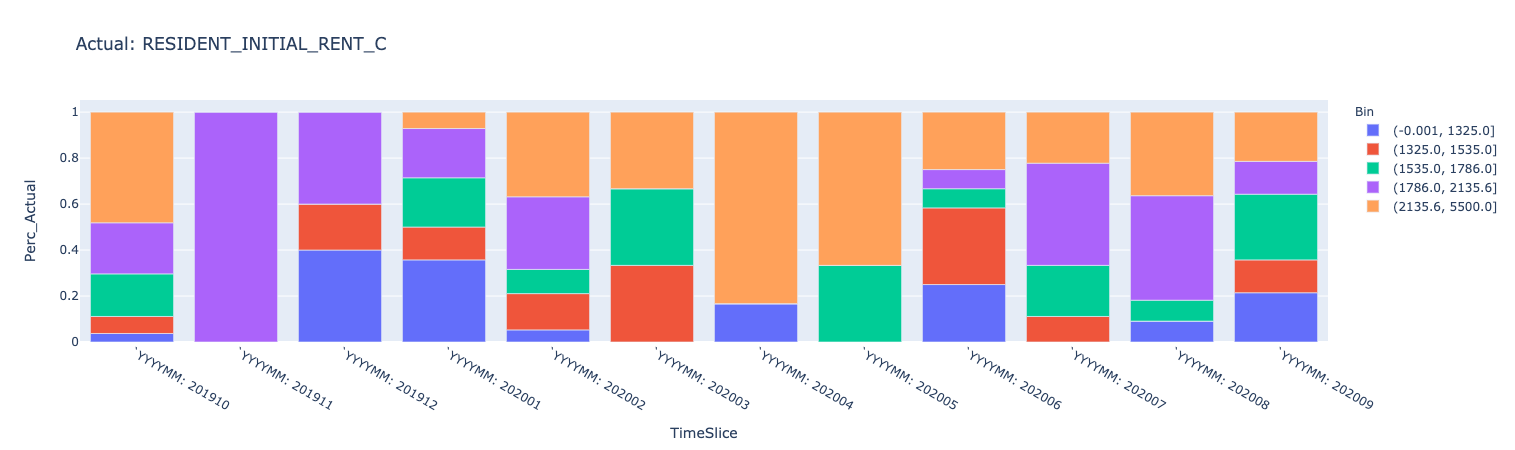

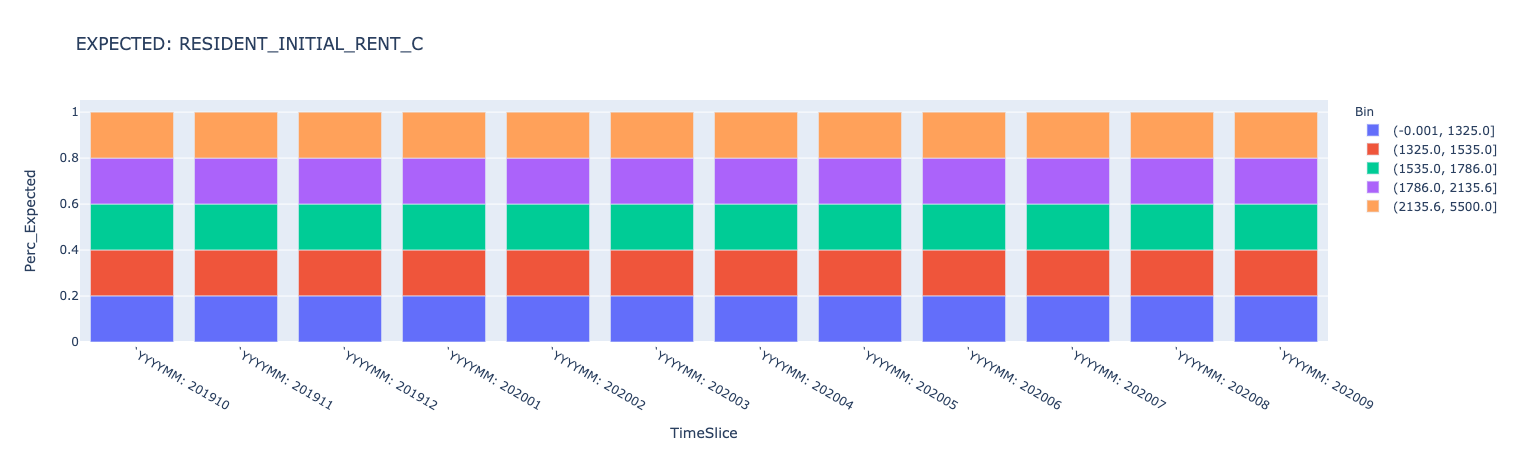

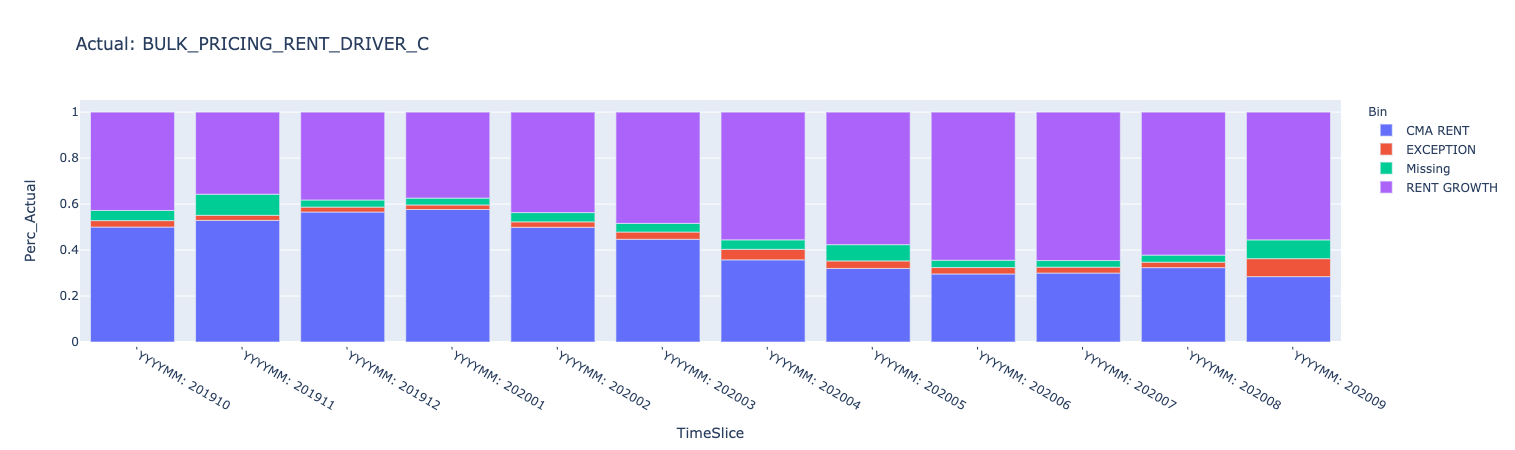

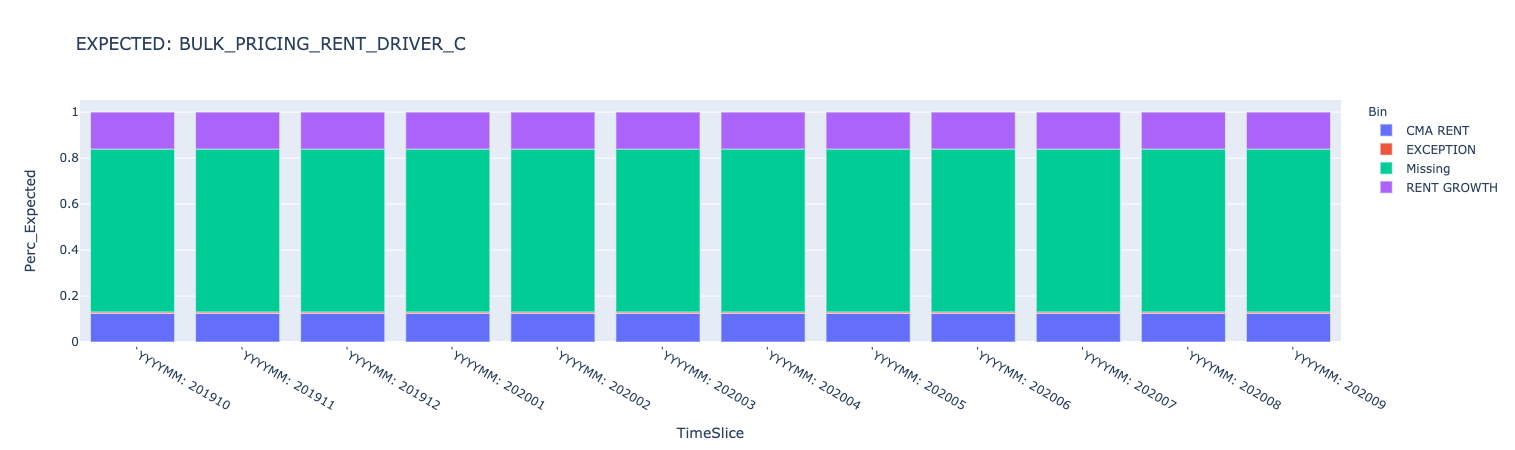

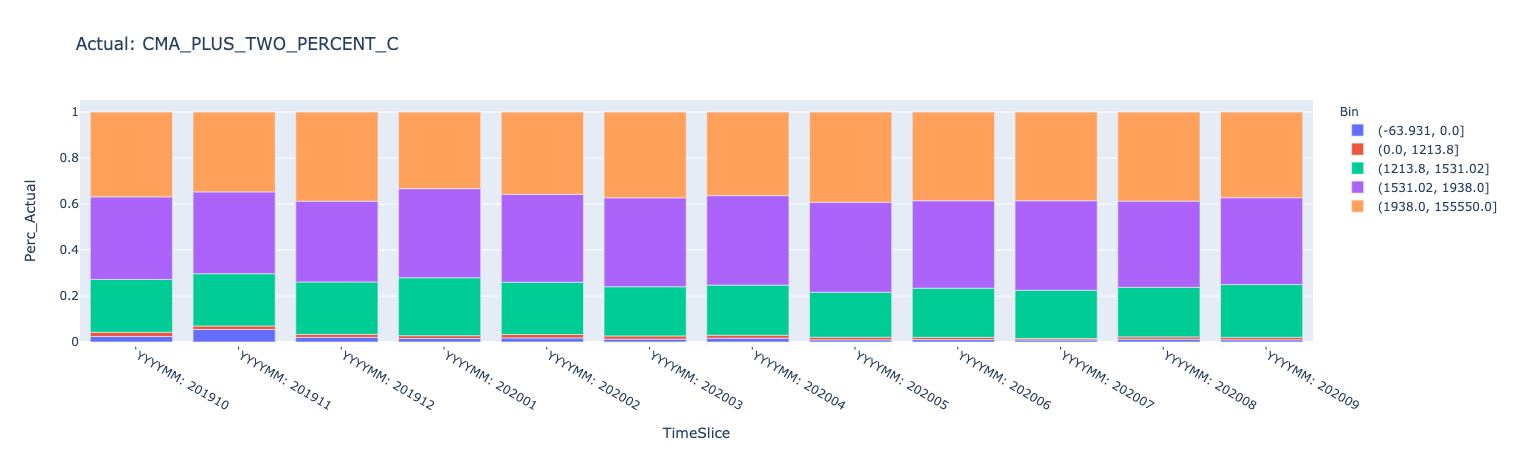

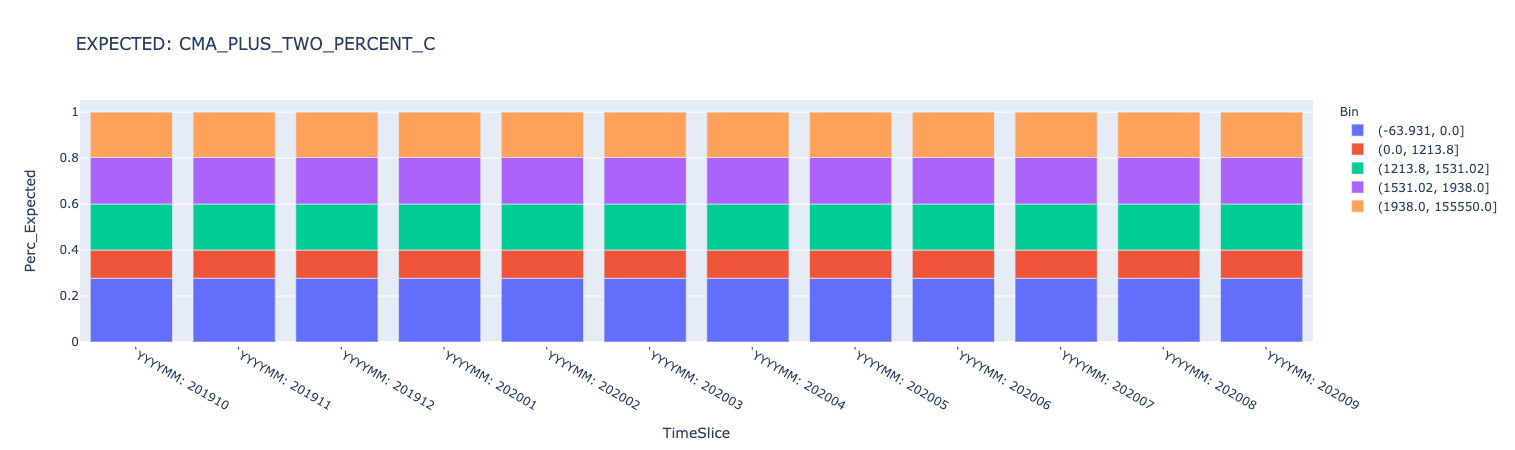

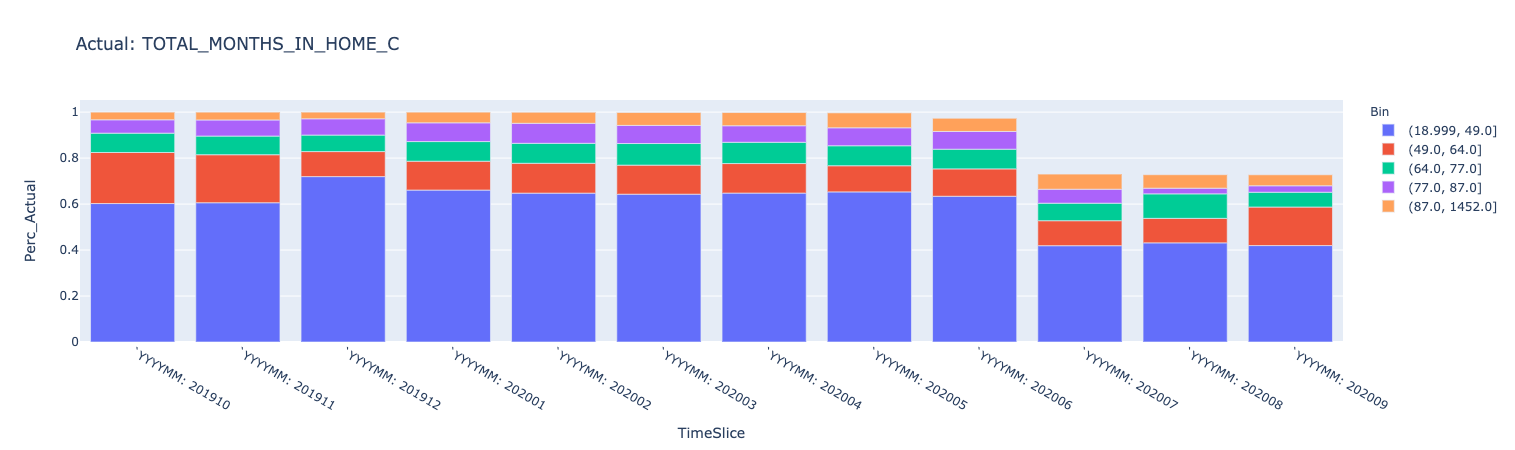

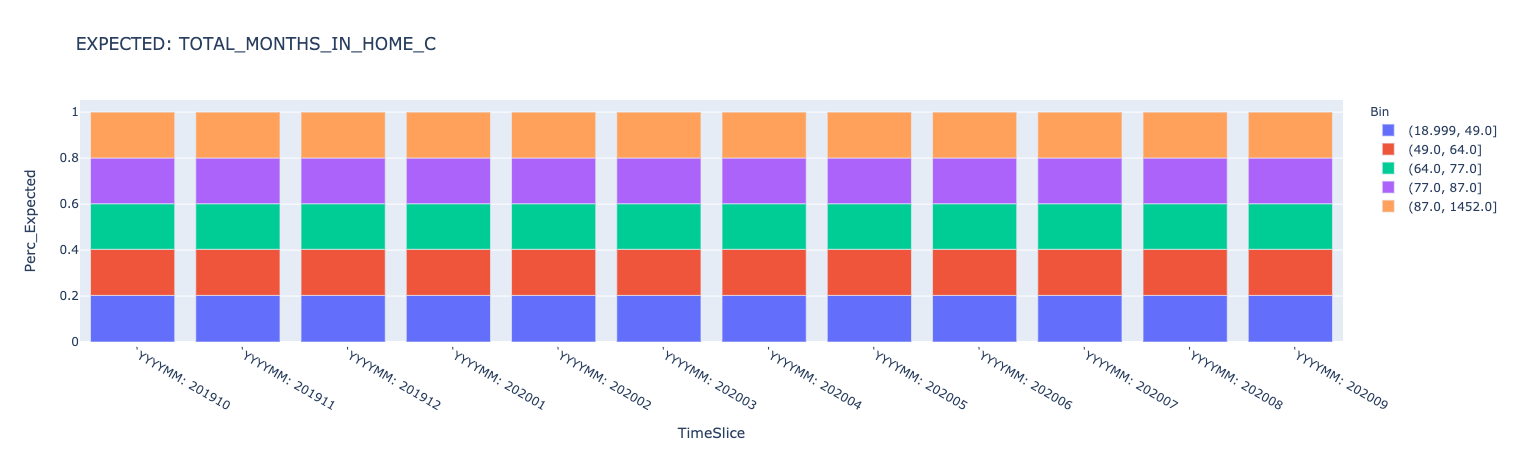

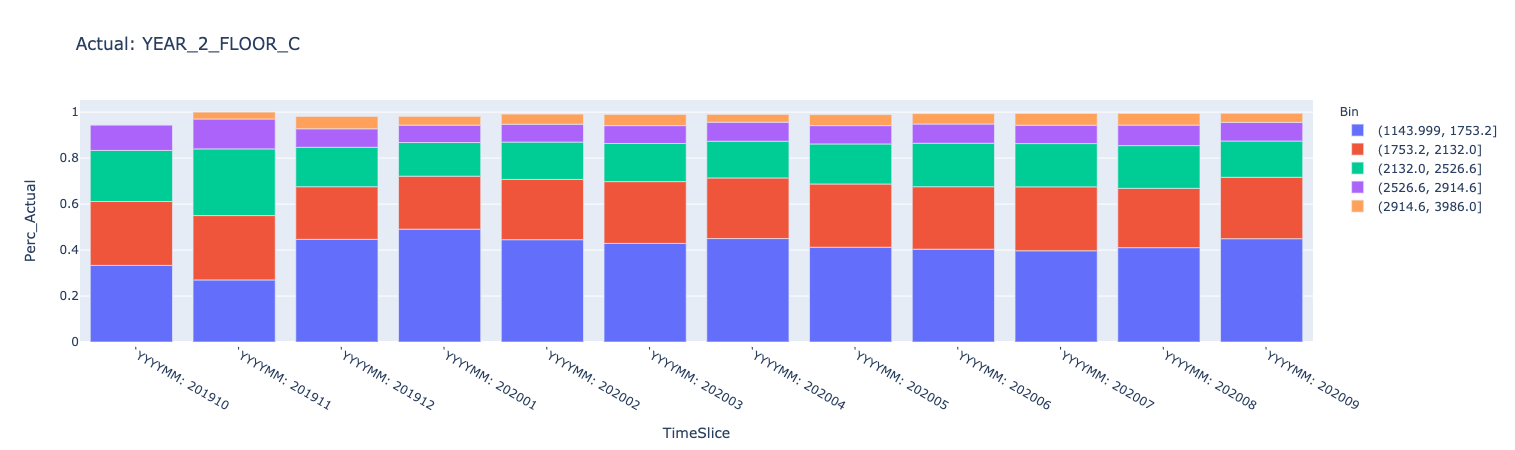

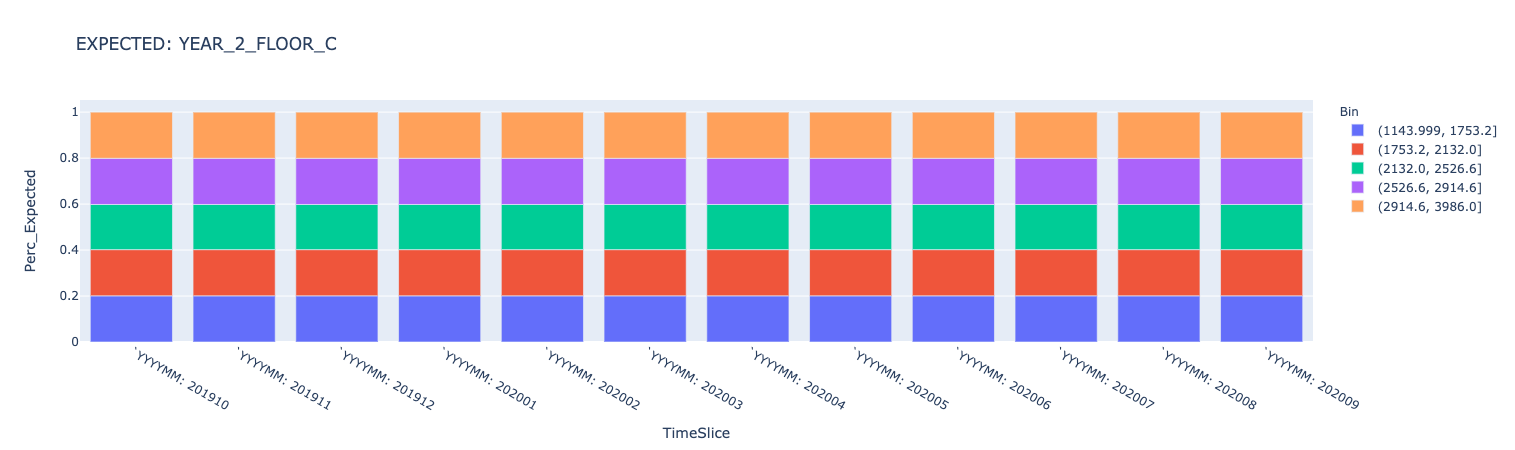

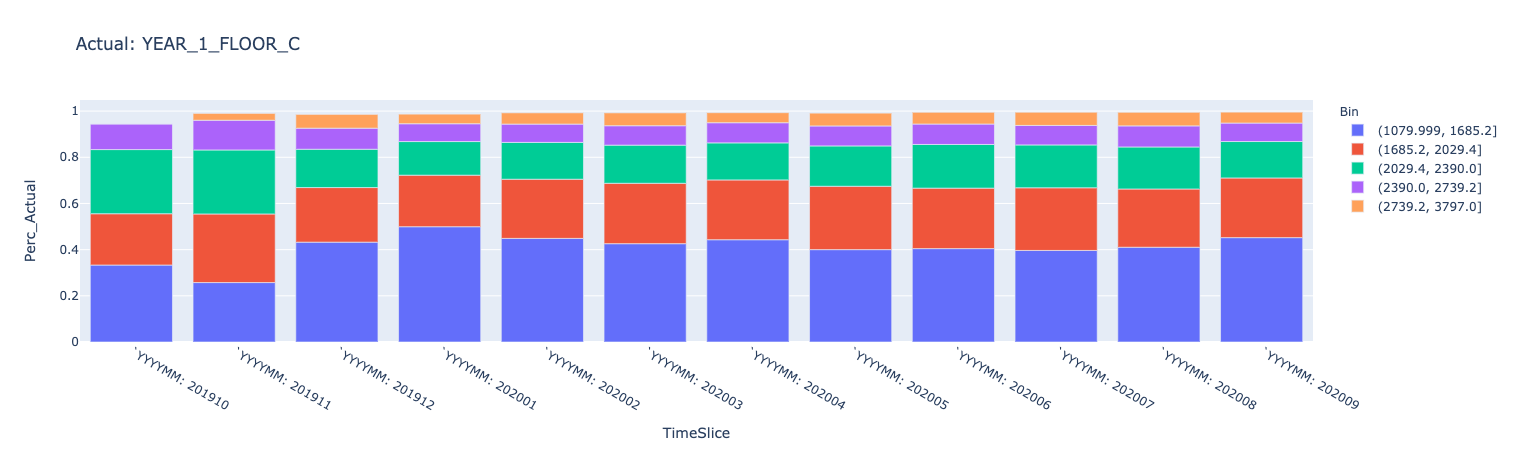

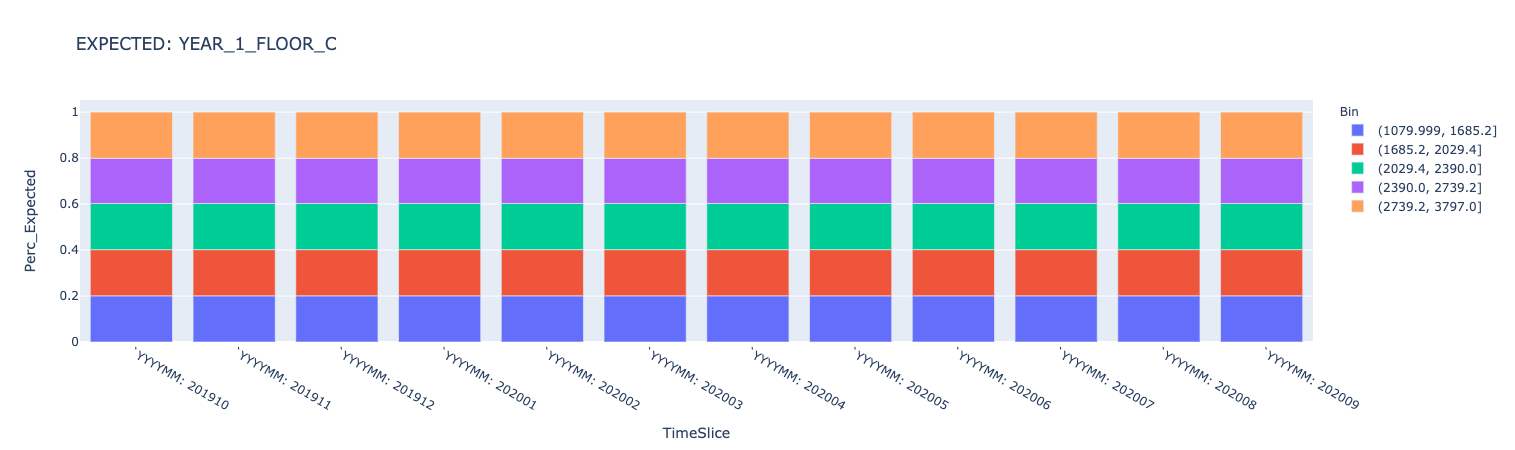

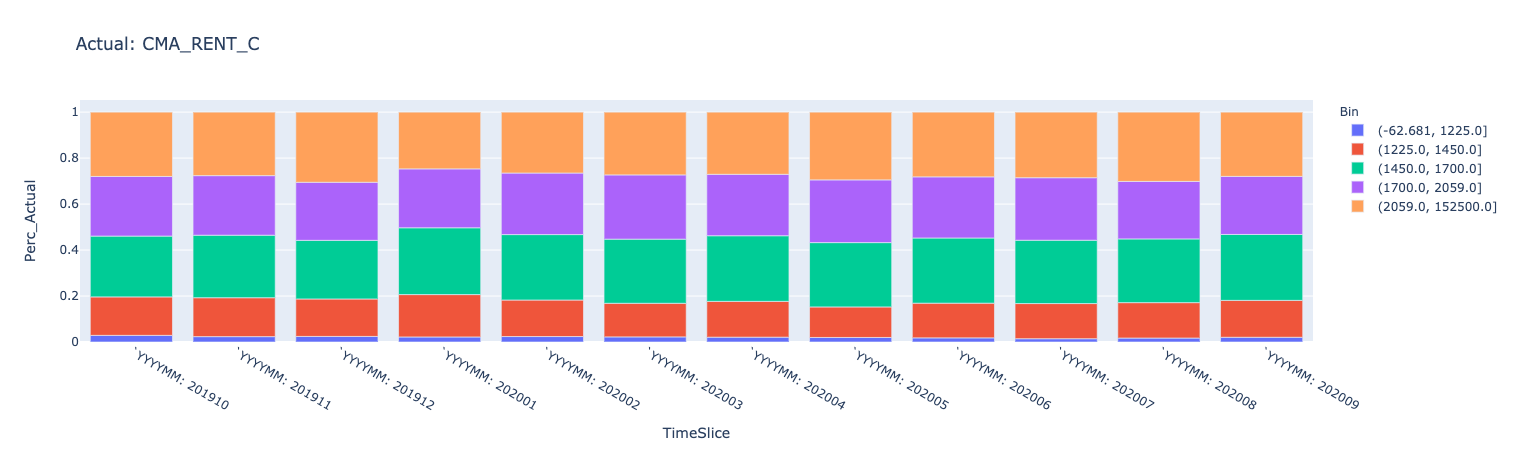

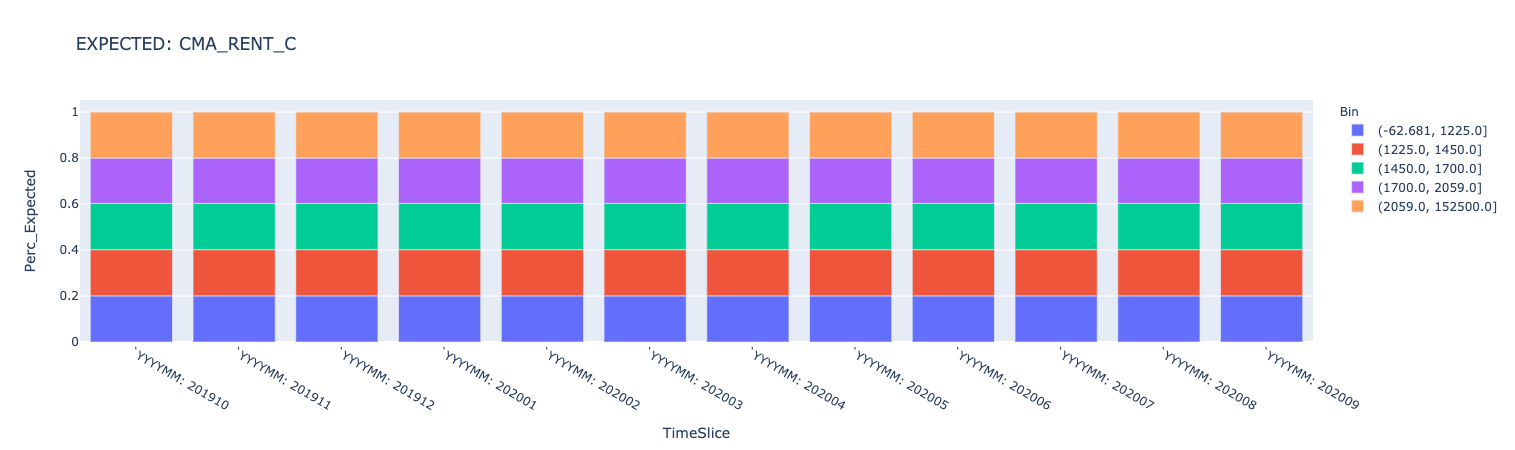

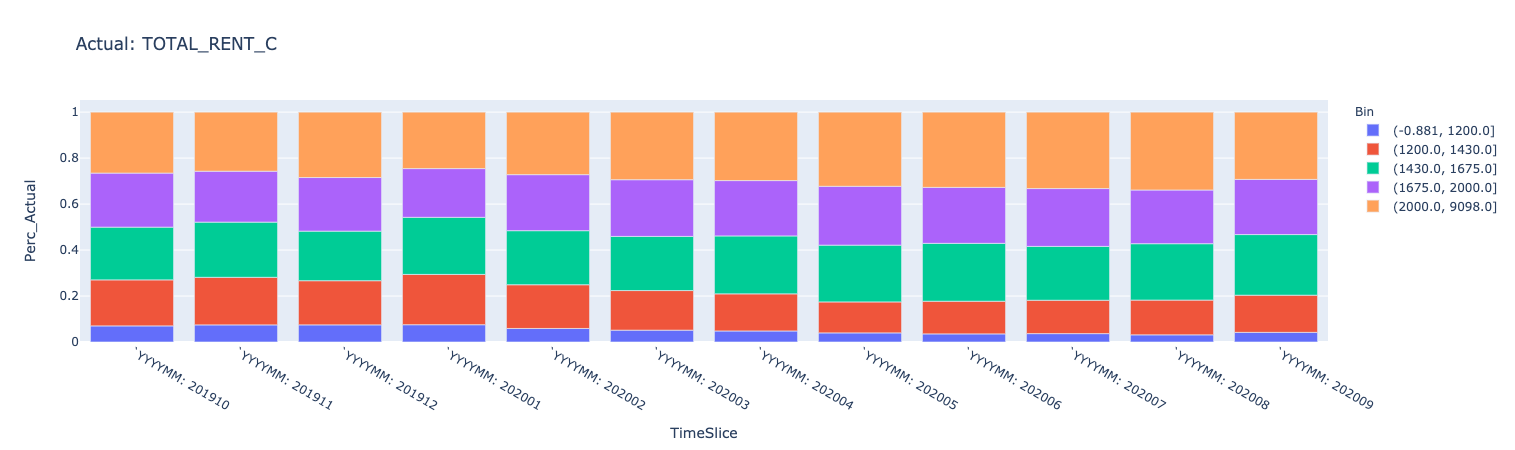

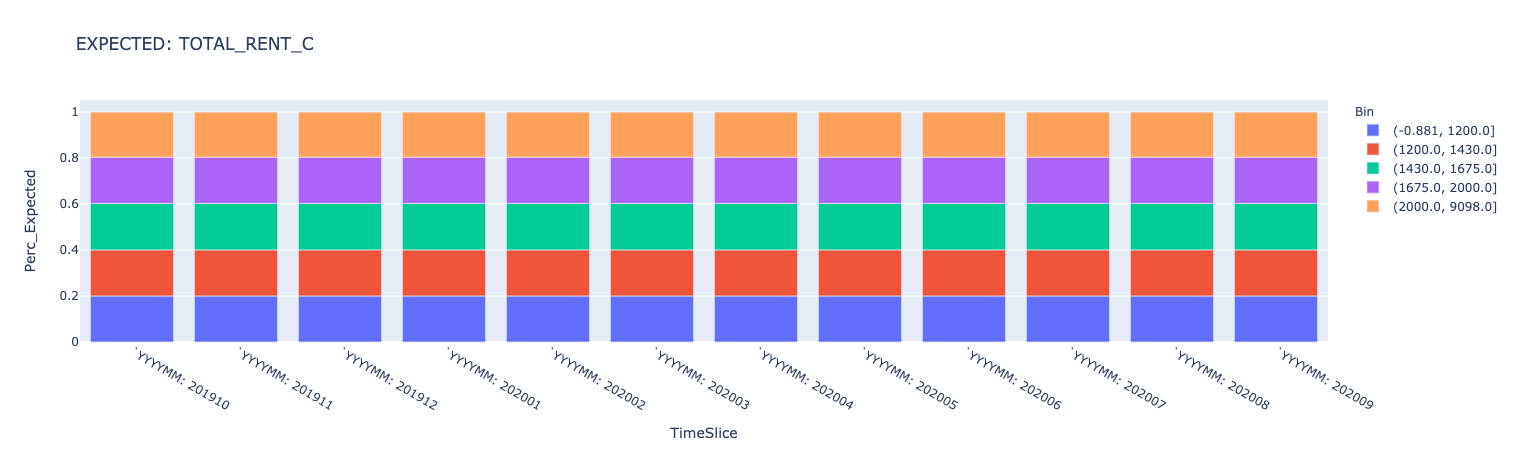

In [37]:
plot_list = pd.DataFrame(result_df[0].groupby(['Variable'])['PSI'].sum()).sort_values(by=['PSI'], axis=0, ascending=False).reset_index()['Variable'].unique().tolist()

for v in plot_list:

    try:
        try:
            del single_result
        except Exception as e:
            pass

        # keep only the var in question
        single_result = result_df[2][result_df[2]['Var'] == v].copy()
        single_result['TimeSlice'] = '`' + single_result['TimeSlice'].astype('str')

        # If the Bin is a range-string with a comma in it, extract the first bin number, to be used for ordering
        if single_result['Bin'].astype('str').str.find(',').max()>0:
            single_result['i'] = single_result['Bin'].apply(lambda x: float(str(x).split(',')[0][1:])).copy()
        else:
            single_result['i'] = single_result['Bin'].copy()

        # re-sort to correct order
        single_result.sort_values(['TimeSlice','i'], ascending=True, inplace=True)

        fig = px.bar(single_result, x="TimeSlice", y="Perc_Actual", color="Bin", title='Actual: ' + v, hover_name="Perc_Expected")
        fig.show()
        fig2 = px.bar(single_result, x="TimeSlice", y="Perc_Expected", color="Bin", title='EXPECTED: ' + v)
        fig2.show()
        print("=".join('' for a in range(100))) 
    
    except Exception as e:
        print(e)
        print("=".join('' for a in range(100))) 

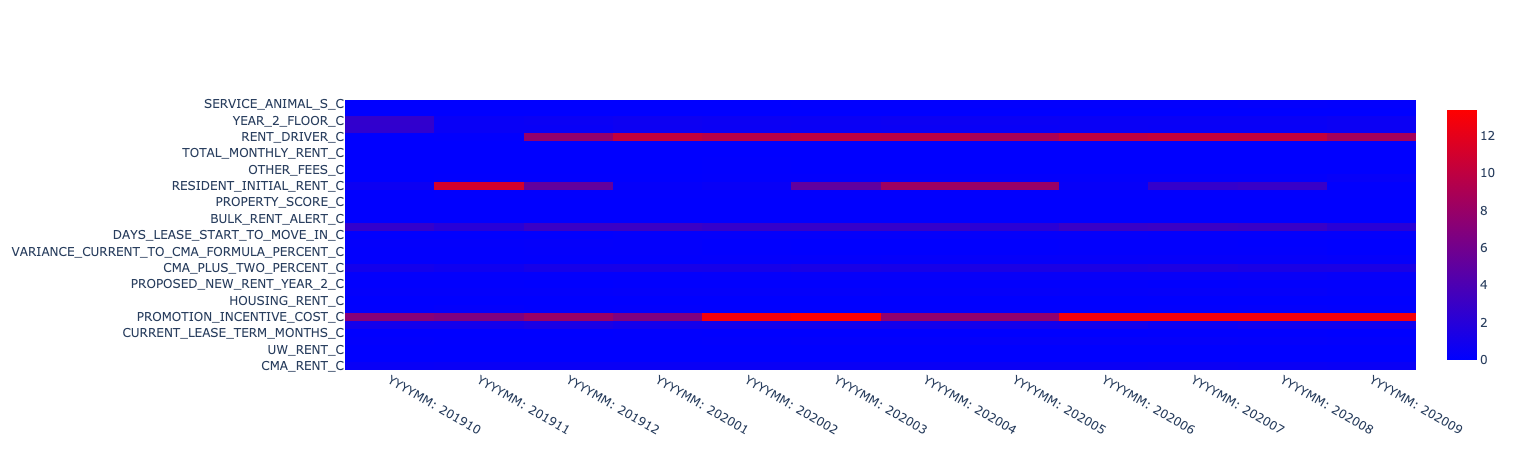

In [38]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
        z=result_df[1]["PSI"],
        x=result_df[1]["TimeSlice"],
        y=result_df[1]["Variable"],
        colorscale='bluered'))
fig.update_xaxes(type='category')
fig.show()